# Define the problem
The given Poisson equation is defined on a unit square domain $[0,1] \times [0,1]$
$$
\begin{aligned}
\Delta u(x,y) &= f(x,y) \\
&=-2\pi ^{2} \sin(\pi x)\sin(\pi y)
\end{aligned}
$$
The boundary condition is set as: $u(x,y)=0$. Dividing the interval evenly into $n$ grids. The width of each grid is $h=\frac{1}{n}$. Set the grid by $\Delta x = \Delta y = h$, we can derivate the following equation:
$$u_{i-1,j} + u_{i,j-1} + u_{i+1,j} +u_{i,j+1} -4u_{i,j} = h^2 f_{i,j}$$
Then we can obtain a linear system:
$$
\mathbf{A}=
\left(

\begin{array}{ccccccc}
-4     & 1      & 0      & \ldots & 1  & 0  &0 & \ldots\\
1      & -4     & 1      & \ldots & 0  & 1  &0 & \ldots\\
\vdots & \vdots & \vdots & \ddots &\vdots & \vdots & \vdots\\
1 & 0 & 0 & \ldots & -4 & 1  &0 & \ldots\\
0      & 1     & 0       & \ldots & 1  & -4 &1 &\ldots\\
\vdots &\vdots &\vdots &\vdots &\vdots &\vdots &\vdots &
\end{array}
\right)

$$
$$
\mathbb{x}=
\left(

\begin{array}{c}
&u_{0,0}\\
&u_{1,0}\\
&u_{2,0}\\
&\vdots \\
&u_{n-1,0}\\
&u_{0,1}\\
&u_{1,1}\\
&\vdots \\
\end{array}
\right)

\mathbb{b}=
\left(

\begin{array}{c}
&f_{0,0}\\
&f_{1,0}\\
&f_{2,0}\\
&\vdots \\
&f_{n-1,0}\\
&f_{0,1}\\
&f_{1,1}\\
&\vdots \\
\end{array}
\right)
$$

# The code part

## Import the necessary module

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time

## Define the right hand vector

In [2]:
def poisson_rhs(n):
    """Generate the right-hand side vector for the given problem."""
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)
    X, Y = np.meshgrid(x, y)
    f = -2*np.pi**2*np.sin(np.pi*X)*np.sin(np.pi*Y)
    return f.flatten()

## Function for Conjugate Gradient Method

In [3]:
def create_A(n):
    """Create the matrix A for the Poisson problem."""
    N = n * n
    A = np.zeros((N, N))
    for i in range(N):
        A[i, i] = -4
        if i - 1 >= 0 and (i % n) != 0:
            A[i, i - 1] = 1
        if i + 1 < N and ((i + 1) % n) != 0:
            A[i, i + 1] = 1
        if i - n  >= 0:
            A[i, i - n ] = 1
        if i + n < N:
            A[i, i + n] = 1
    return A

def conjugate_gradient(A, b, tol=1e-10, max_iter=1000):
    """Solve Ax = b using the Conjugate Gradient method."""
    x = np.zeros_like(b)
    r = b - A @ x
    d = r.copy()
    rs_old = np.dot(r, r)

    for i in range(max_iter):
        Ad = A @ d
        alpha = rs_old / np.dot(d, Ad)
        x += alpha * d
        r -= alpha * Ad
        rs_new = np.dot(r, r)
        if np.sqrt(rs_new) < tol:
            break
        d = r + (rs_new / rs_old) * d
        rs_old = rs_new

    return x


## Function for Multi-Grid Method

In [4]:
def relax(A, u, f, nu):
    """Perform nu Gauss-Seidel relaxations for the system Au=f."""
    N = len(f)
    h = 1.0 / np.sqrt(N + 1)
    for _ in range(nu):
        for i in range(N):
            residual = f[i] - A[i] @ u
            u[i] += residual / (4 / h**2)
    return u

def interpolate(u_coarse, n_fine):
    """Interpolate solution from coarse grid to fine grid."""
    n_coarse = int(np.sqrt(len(u_coarse)))
    u_fine = np.zeros((n_fine, n_fine))
    u_coarse = u_coarse.reshape((n_coarse, n_coarse))
    for i in range(n_coarse):
        for j in range(n_coarse):
            u_fine[2*i:2*(i+1), 2*j:2*(j+1)] = u_coarse[i, j]
    return u_fine.flatten()

def restrict(u_fine, n_coarse):
    """Restrict solution from fine grid to coarse grid."""
    n_fine = int(np.sqrt(len(u_fine)))
    u_coarse = np.zeros((n_coarse, n_coarse))
    u_fine = u_fine.reshape((n_fine, n_fine))
    for i in range(n_coarse):
        for j in range(n_coarse):
            u_coarse[i, j] = np.mean(u_fine[2*i:2*(i+1), 2*j:2*(j+1)])
    return u_coarse.flatten()

def two_grid(A_fine, u_fine, f_fine, A_coarse, f_coarse, nu):
    """Perform one two-grid cycle."""
    # Pre-relaxation
    u_fine = relax(A_fine, u_fine, f_fine, nu)

    # Compute residual and restrict to coarse grid
    residual_fine = f_fine - A_fine @ u_fine
    residual_coarse = restrict(residual_fine, int(np.sqrt(len(f_coarse))))

    # Solve on coarse grid
    u_coarse = np.zeros_like(f_coarse)
    u_coarse = np.linalg.solve(A_coarse, residual_coarse)

    # Interpolate to fine grid and correct
    correction_fine = interpolate(u_coarse, int(np.sqrt(len(u_fine))))
    u_fine += correction_fine

    # Post-relaxation
    u_fine = relax(A_fine, u_fine, f_fine, nu)

    return u_fine

## Solve the problem

In [5]:
n = 64  # Grid size
A = create_A(n)
b = poisson_rhs(n)

# CG solution
start_time = time.time()
solution_cg = conjugate_gradient(A, b)
end_time = time.time()
print("CG solution took {:.2f} seconds".format(end_time - start_time))
solution_grid_cg = solution_cg.reshape((n, n))

# Two-grid solution
# Create coarse grid operators
n_coarse = n // 2
A_coarse = create_A(n_coarse)
f_coarse = restrict(poisson_rhs(n), n_coarse)
u_fine = np.zeros_like(b)
start_time = time.time()
solution_two_grid = two_grid(A, u_fine, b, A_coarse, f_coarse, nu=3)
end_time = time.time()
print("Two-grid solution took {:.2f} seconds".format(end_time - start_time))
solution_grid_two_grid = solution_two_grid.reshape((n, n))

CG solution took 0.04 seconds
Two-grid solution took 0.80 seconds


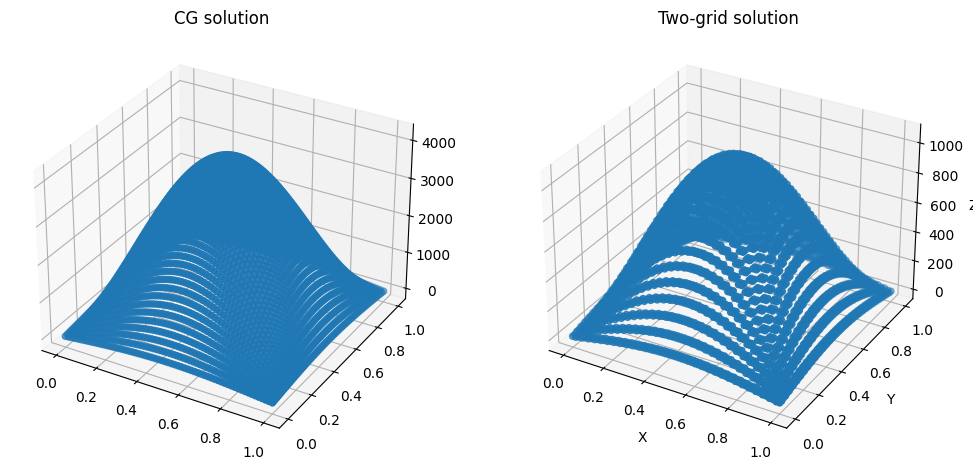

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X, Y, solution_grid_cg, marker='o', )
ax.title.set_text('CG solution')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(X, Y, solution_grid_two_grid, marker='o', )
ax.title.set_text('Two-grid solution')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### Set the number of grid to 128

CG solution took 0.76 seconds
Two-grid solution took 9.78 seconds


Text(0.5, 0, 'Z')

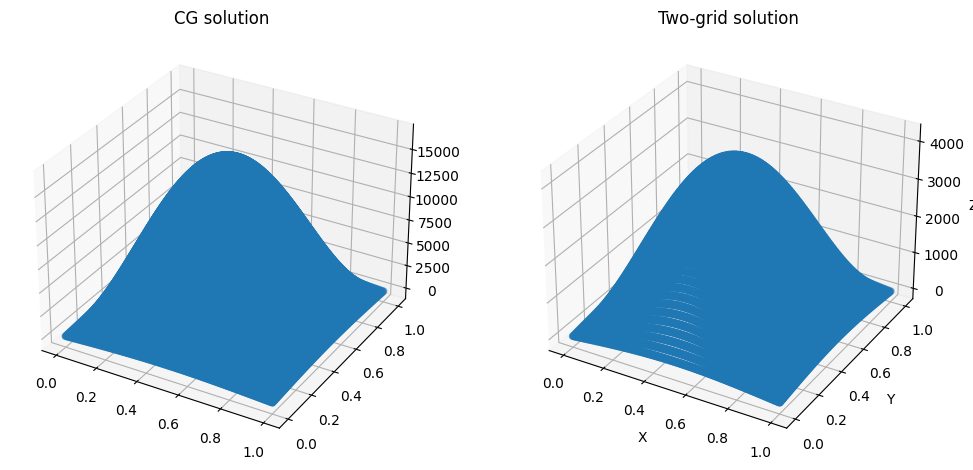

In [7]:
import time

n = 128  # Grid size
A = create_A(n)
b = poisson_rhs(n)

# CG solution
start_time = time.time()
solution_cg = conjugate_gradient(A, b)
end_time = time.time()
print("CG solution took {:.2f} seconds".format(end_time - start_time))
solution_grid_cg = solution_cg.reshape((n, n))

# Two-grid solution
# Create coarse grid operators
n_coarse = n // 2
A_coarse = create_A(n_coarse)
f_coarse = restrict(poisson_rhs(n), n_coarse)
u_fine = np.zeros_like(b)
start_time = time.time()
solution_two_grid = two_grid(A, u_fine, b, A_coarse, f_coarse, nu=3)
end_time = time.time()
print("Two-grid solution took {:.2f} seconds".format(end_time - start_time))
solution_grid_two_grid = solution_two_grid.reshape((n, n))

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X, Y, solution_grid_cg, marker='o', )
ax.title.set_text('CG solution')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(X, Y, solution_grid_two_grid, marker='o', )
ax.title.set_text('Two-grid solution')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

### From the calculation results, it can be found that when the number of grids increases from 64 to 128, the calculation time of the multi-grid method increases significantly, while the time of the conjugate gradient method does not increase much.